<a href="https://colab.research.google.com/github/kevincong95/cs231n-emotiw/blob/master/notebooks/2.0-la-tj-ak-ensemble_baseline_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Video Sentiment Analysis in the Wild
### Ensembling Notebook | CS231n

This notebook preprocesses input videos to extract faces, frames, poses, and audio before running pre-trained models for each modality to predict group sentiment (positive, negative, or neutral). 

In [1]:
# Clone the code base
!git clone 'https://github.com/kevincong95/cs231n-emotiw.git'

# Switch to TF 1.x and navigate to the directory
%tensorflow_version 1.x
!pwd
import os
os.chdir('cs231n-emotiw')
!pwd

# Install required packages 
!pip install -r 'requirements-predictions.txt'


Cloning into 'cs231n-emotiw'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 754 (delta 42), reused 27 (delta 16), pack-reused 683
Receiving objects: 100% (754/754), 175.22 MiB | 38.52 MiB/s, done.
Resolving deltas: 100% (450/450), done.
TensorFlow 1.x selected.
/content
/content/cs231n-emotiw
     |████████████████████████████████| 389kB 8.6MB/s 
     |████████████████████████████████| 634kB 15.3MB/s 
     |████████████████████████████████| 3.3MB 23.9MB/s 
     |████████████████████████████████| 26.9MB 115kB/s 
     |████████████████████████████████| 337kB 60.0MB/s 
     |████████████████████████████████| 25.4MB 122kB/s 
     |████████████████████████████████| 100.2MB 30kB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-cp36-none-any.whl size=110728 sha256=e033b553a1ab145e85033de0edfc035685703d793ef5a4eb2400d84c2f461fd1
  Stored in directory: /root/.cache/pip/wheels/e0/fe/1c/f

#### Pose Pre-Requisites
Pose extraction uses the [CMU OpenPose library](https://github.com/CMU-Perceptual-Computing-Lab/openpose) to extract body keypoints. We have pre-compiled this library for use in Colab but some system files still need to be installed. 

#### Retrieve the files

The code block below demonstrates how to retrieve the files from GCS. However, feel free to skip this step if the files are already on the local disk or you have Google Drive mounted.

In [2]:
!ls

 data	   notebooks   requirements-predictions.txt		   src
 LICENSE   README.md   requirements.txt
 models    reports    'Screen Shot 2020-05-26 at 8.53.32 PM.png'


In [3]:
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
!wget https://storage.googleapis.com/cs231n-emotiw/openpose/openpose.tar.gz
!tar -xzf openpose.tar.gz

# The pre-built OpenPose library contains shared library files that need to be manually linked
import os
orig_lib_path = os.environ['LD_LIBRARY_PATH']
os.environ["LD_LIBRARY_PATH"] = f"{orig_lib_path}:{os.getcwd()}/openpose/build/src/openpose/:{os.getcwd()}/openpose/build/caffe/lib/"

!wget https://storage.googleapis.com/cs231n-emotiw/data/train-tiny.zip
!wget https://storage.googleapis.com/cs231n-emotiw/data/val-tiny.zip
!wget https://storage.googleapis.com/cs231n-emotiw/data/test-tiny.zip
!wget https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
!wget https://storage.googleapis.com/cs231n-emotiw/data/Val_labels.txt


Selecting previously unselected package libgflags2.2.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

#### Preprocess Files

Here, we will instantiate each of the preprocessors and process all of the input video files.

NOTE: Change the input parameters as needed.

WARNING: This may take several hours to complete, depending on the number of files.

In general, pre-processing will extract the following:
- Video frames
- Pose keypoints
- Faces from each video frame
- Audio waveform and audio features

In [0]:
from src.preprocessors.preprocess_all_modes import preprocess
from src.preprocessors.pose_preprocessor import PosePreprocessor

print("Starting to preprocess train data")
preprocess(video_folder="train-tiny.zip", label_file="Train_labels.txt", local_base_path="train-tiny")

print("Starting to preprocess val data")
preprocess(video_folder="val-tiny.zip", label_file="Val_labels.txt", local_base_path="val-tiny")

print("Starting to preprocess test data")
preprocess(video_folder="test-tiny.zip", local_base_path="test-tiny")


In [0]:
# Remove the openpose folder as it is no longer required
!rm -rf openpose/

In [5]:
!ls

 data					     train-tiny-audio_tmp
 LICENSE				     train-tiny-audio.zip
 models					     train-tiny-faces
 notebooks				     train-tiny-faces_tmp
 openpose.tar.gz			     train-tiny-faces.zip
 README.md				     train-tiny-frames
 reports				     train-tiny-frames_tmp
 requirements-predictions.txt		     train-tiny-frames.zip
 requirements.txt			     train-tiny-pose
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   train-tiny-pose.zip
 src					     train-tiny.zip
 test-tiny-audio			     Val_labels.txt
 test-tiny-audio_tmp			     val-tiny-audio
 test-tiny-audio.zip			     val-tiny-audio_tmp
 test-tiny-faces			     val-tiny-audio.zip
 test-tiny-faces_tmp			     val-tiny-faces
 test-tiny-faces.zip			     val-tiny-faces_tmp
 test-tiny-frames			     val-tiny-faces.zip
 test-tiny-frames_tmp			     val-tiny-frames
 test-tiny-frames.zip			     val-tiny-frames_tmp
 test-tiny-pose				     val-tiny-frames.zip
 test-tiny-pose.zip			     val-tiny-pose
 test-tiny.zip				     val-tiny-pose.zip
 Train_label

In [15]:
from google.colab import drive
drive.mount('/content/drive')

!cp train-tiny-*.zip "/content/drive/My Drive/cs231n-project/datasets/emotiw"
!cp val-tiny-*.zip "/content/drive/My Drive/cs231n-project/datasets/emotiw"
!cp test-tiny-*.zip "/content/drive/My Drive/cs231n-project/datasets/emotiw"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Run Classifiers

**IMPORTANT**: You must restart the runtime at this point to use TF 2.x

In [0]:
%tensorflow_version 2.x

In [2]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [3]:
!pwd
import os
os.chdir('cs231n-emotiw')
!pwd


/content
/content/cs231n-emotiw


In [4]:
!git pull

remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 42 (delta 31), reused 22 (delta 16), pack-reused 0
Unpacking objects: 100% (42/42), done.
From https://github.com/kevincong95/cs231n-emotiw
   6256967..8e9c7e4  master     -> origin/master
 * [new branch]      fer        -> origin/fer
Updating 6256967..8e9c7e4
Fast-forward
 notebooks/1.0-la-audio-error-analysis.ipynb |  879 ++++++++++++++++++
 notebooks/scene/1.0-tj-resnet-lstm.ipynb    | 1271 ++++++++++++++++++++++++++-
 src/generators/frame_generator.py           |    8 +-
 src/generators/pose_generator.py            |    8 +-
 4 files changed, 2154 insertions(+), 12 deletions(-)
 create mode 100644 notebooks/1.0-la-audio-error-analysis.ipynb


In [6]:
from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

audio_classifier = AudioClassifier('train-tiny-audio', model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
frames_classifier = FramesClassifier('train-tiny-frames', model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
pose_classifier = PoseClassifier('train-tiny-pose', model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
#faces_classifier = 

classifiers = [audio_classifier, frames_classifier, pose_classifier]

sample_to_true_label = {}
with open("Train_labels.txt") as f:
    l = 0
    for line in f:
        if l == 0:
            # Skip headers
            l += 1
            continue
        line_arr = line.split(" ")
        sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip())
        l += 1



AudioClassifier created with audio_folder = train-tiny-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-tiny-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
121389056/121384640 [==============================] - 2s 0us/step
PoseClassifier created with pose_folder = train-tiny-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
614400/612904 [==============================] - 0s 0us/step


In [7]:
audio_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 6144)]      0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          786496    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 512)         2048  

In [8]:
frames_classifier.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_15[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D)    (None, 12, 10, 15, 1 740920      time_distributed_7[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D)    (None, 12, 10, 15, 1 740920      time_distributed_7[0][0]         
____________________________________________________________________________________________

In [9]:
pose_classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 27)]          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               47104     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 47,491
Trainable params: 47,491
Non-trainable params: 0
_________________________________________________________________


In [0]:
def predict(classifiers, sample_to_true_label=None, mode="soft", complex_fusion=False, weights=[]):
    assert mode in ["soft" , "hard", "weighted"]
    from collections import Counter

    classifier_outputs = []
    classifier_samples = []
    sample_to_row = {}
    num_samples = 0
    y_true = []

    for c, classifier in enumerate(classifiers):
        results, samples = classifier.predict()
        classifier_outputs.append(results.tolist())
        classifier_samples.append(list(samples))
        num_samples = len(list(samples))

    print(f"Number of samples: {num_samples}")

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        if sample_to_true_label is not None:
            y_true.append(sample_to_true_label[sample])

    X = np.zeros(shape=(len(classifiers), num_samples, 3))
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        for i, row in enumerate(output):
            sample = samples[i]
            X[c, sample_to_row[sample], :] += row

    print(X[:, 10, :])

    if mode == "weighted":
        for c in range(X.shape[0]):
            X[c, :, :] = weights[c] * X[c, :, :]

        y_pred = np.sum(X, axis=0)
        y_pred = np.argmax(y_pred, axis=1) + 1 # Add 1 because true labels range from 1 to 3
        if sample_to_true_label is not None:
            y_true = np.array(y_true)

        print("Predicted y-labels:")
        print(y_pred)

        if sample_to_true_label is not None:
            print("True y-labels:")
            print(y_true)

            accuracy = (y_pred == y_true).mean()
            print(f"Accuracy: {accuracy}")
            return y_pred , y_true

    if mode == "soft":
        # Take the average of each 
        y_pred = np.mean(X, axis=0)
        y_pred = np.argmax(y_pred, axis=1) + 1 # Add 1 because true labels range from 1 to 3
        if sample_to_true_label is not None:
            y_true = np.array(y_true)

        print("Predicted y-labels:")
        print(y_pred)

        if sample_to_true_label is not None:
            print("True y-labels:")
            print(y_true)

            accuracy = (y_pred == y_true).mean()
            print(f"Accuracy: {accuracy}")
            return y_pred , y_true

    if mode == "hard":
        # Take the majority vote of each

        y_pred_tmp = np.zeros((len(classifier_outputs) , len(classifier_outputs[0])))

        
        for i in range(0 , X.shape[0]):
          for j in range(0 , X.shape[1]):
            y_pred_tmp[i][j] = np.argmax(X[i][j], axis=0) + 1.0
            
         
        y_pred_tmp = y_pred_tmp.T
        y_pred_tmp = np.asarray(y_pred_tmp , dtype='int64')
        
        y_pred = np.zeros((X.shape[1]))

        for i in range(0 , len(y_pred_tmp)):
          y_pred_tmp[i] = np.asarray(y_pred_tmp[i] , dtype='int64')
          counts = np.bincount(y_pred_tmp[i])
          y_pred[i] = np.argmax(counts)

        
      
   # Add 1 because true labels range from 1 to 3
        if sample_to_true_label is not None:
            y_true = np.array(y_true)

        print("Predicted y-labels:")
        print(y_pred)

        if sample_to_true_label is not None:
            print("True y-labels:")
            print(y_true)

            accuracy = (y_pred == y_true).mean()
            print(f"Accuracy: {accuracy}")
            return y_pred , y_true
    else:
        print("Not implemented yet")

    


In [48]:
from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

audio_classifier = AudioClassifier('val-tiny-audio', model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
frames_classifier = FramesClassifier('val-tiny-frames', model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
pose_classifier = PoseClassifier('val-tiny-pose', model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)

classifiers = [audio_classifier, frames_classifier, pose_classifier] 
# classifiers = [audio_classifier] 

# Audio Classifier = 0.5
# Frames classifier = 0.56
# Pose classifier = 0.48

sample_to_true_label = {}
with open("Val_labels.txt") as f:
    l = 0
    for line in f:
        if l == 0:
            # Skip headers
            l += 1
            continue
        line_arr = line.split(" ")
        sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip())
        l += 1
print(sample_to_true_label)


AudioClassifier created with audio_folder = val-tiny-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = val-tiny-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = val-tiny-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
{'1_1': 3, '1_2': 3, '5_1': 1, '5_2': 1, '5_3': 1, '5_4': 1, '5_5': 1, '5_6': 1, '5_7': 1, '5_8': 1, '5_9': 1, '5_10': 1, '5_11': 1, '5_12': 1, '5_13': 1, '5_14': 1, '5_15': 1, '5_16': 1, '5_17': 1, '5_18': 1, '5_19': 1, '11_1': 2, '11_2': 1, '11_3': 1, '11_4': 1, '11_5': 1, '11_6': 1, '11_7': 1, '11_8': 1, '11_9': 1, '11_10': 1, '11_11': 1, '11_12': 1, '11_13': 2, '11_14': 1, '11_15': 1, '11_16': 1, '11_17': 1, '15_2': 2, '15_3': 2, '15_4': 2, '15_5': 1,

## Weighted Voting Results

In [49]:
y_pred_soft , y_true = predict(classifiers, sample_to_true_label, mode="weighted", weights=[0.4, 0.5, 0.1])


Skipping unzipping files as input is a folder
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Skipping unzipping files as input is a folder
Found 50 frames belonging to 50 videos belonging to 3 classes.
Min frames determined to be 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, exp

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Number of samples: 50
[[0.18311593 0.27824757 0.53863645]
 [0.52522397 0.39609671 0.07867933]
 [0.28853178 0.24969785 0.46177036]]
Predicted y-labels:
[3 3 3 2 2 2 1 2 1 1 1 1 2 2 2 2 2 2 3 2 3 2 1 2 2 2 2 2 2 2 2 3 2 2 3 2 3
 1 2 2 2 1 2 2 3 3 1 3 1 3]
True y-labels:
[3 3 3 1 1 1 1 3 1 2 1 3 2 2 2 2 2 1 1 1 1 1 2 2 1 2 2 2 2 2 2 3 3 3 1 3 1
 1 1 2 1 1 1 2 2 1 1 3 1 3]
Accuracy: 0.54


## Soft Voting Results

In [41]:
y_pred_soft , y_true = predict(classifiers, sample_to_true_label)

Skipping unzipping files as input is a folder
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Skipping unzipping files as input is a folder
Found 50 frames belonging to 50 videos belonging to 3 classes.
Min frames determined to be 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, exp

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Number of samples: 50
[[0.18311593 0.27824757 0.53863645]
 [0.52522397 0.39609671 0.07867933]
 [0.28853178 0.24969785 0.46177036]]
Predicted y-labels:
[3 3 3 2 2 2 1 2 1 1 3 1 2 2 2 2 2 2 3 2 3 2 1 2 2 2 2 2 2 2 2 3 3 2 3 2 3
 1 2 2 2 1 2 2 3 3 1 3 1 3]
True y-labels:
[3 3 3 1 1 1 1 3 1 2 1 3 2 2 2 2 2 1 1 1 1 1 2 2 1 2 2 2 2 2 2 3 3 3 1 3 1
 1 1 2 1 1 1 2 2 1 1 3 1 3]
Accuracy: 0.54


## F1 Score -- Soft Voting


In [21]:
from sklearn.metrics import f1_score

f1_score(y_true, y_pred_soft, average='micro')

0.54

## Confusion Matrix -- Soft Voting

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


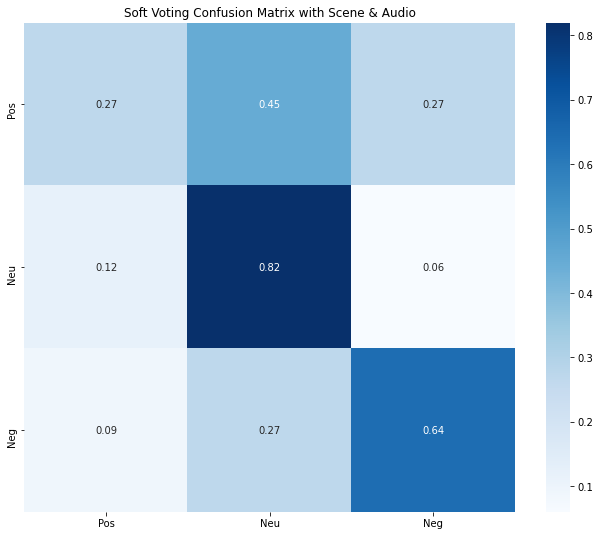

In [22]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_true,y_pred_soft)
import matplotlib.pyplot as plt


classes=['Pos' , 'Neu' , 'Neg'] 

y_pred_final , y_true_final = y_pred_soft - 1 , y_true - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)


figure = plt.figure(figsize=(11, 9))
plt.title("Soft Voting Confusion Matrix with Scene & Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)

## Hard Voting Results

In [23]:
y_pred_hard , y_true = predict(classifiers, sample_to_true_label , mode="hard")

Skipping unzipping files as input is a folder
Skipping unzipping files as input is a folder
Found 50 frames belonging to 50 videos belonging to 3 classes.
Min frames determined to be 7
Skipping unzipping files as input is a folder
['1', '3', '2']
Found 50 frames belonging to 50 videos belonging to 3 classes.
Min frames determined to be 7


/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 50
Predicted y-labels:
[3. 3. 3. 2. 2. 2. 1. 2. 1. 1. 3. 1. 1. 2. 1. 1. 2. 1. 3. 2. 3. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 3. 3. 1. 3. 1. 1. 1. 2. 2. 2. 1. 2. 2. 3. 1. 1. 1.
 1. 1.]
True y-labels:
[3 3 3 1 1 1 1 3 1 2 1 3 2 2 2 2 2 1 1 1 1 1 2 2 1 2 2 2 2 2 2 3 3 3 1 3 1
 1 1 2 1 1 1 2 2 1 1 3 1 3]
Accuracy: 0.52


In [24]:
f1_score(y_true, y_pred_hard, average='micro')

0.52

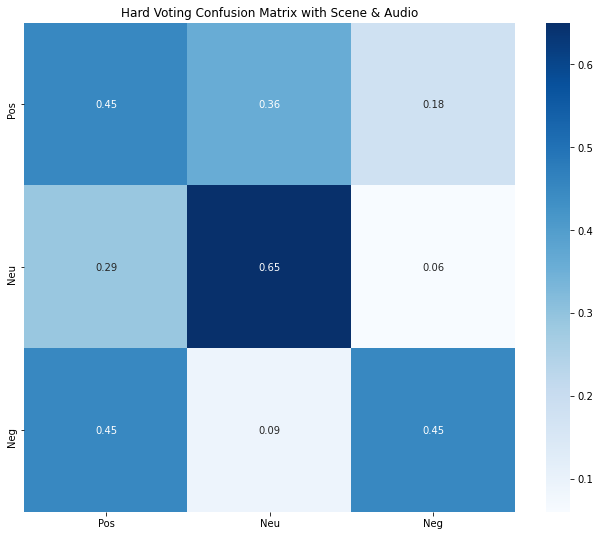

In [25]:
y_pred_final , y_true_final = y_pred_hard - 1 , y_true - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)


figure = plt.figure(figsize=(11, 9))
plt.title("Hard Voting Confusion Matrix with Scene & Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)